# Practical Assignment 5
#### *Submitted by Mukul Aryal (CS IV/I)*
##### Predicting Bitcoin prices using LSTM model

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import warnings
import logging

tf.disable_v2_behavior()
logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

2025-04-28 18:32:07.928401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 18:32:07.928912: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 18:32:07.932052: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 18:32:07.939396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745844427.952108   18323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745844427.95

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# roead data
df = pd.read_csv("data/btc.csv")
df.head(5)

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [3]:
# Get closing price of BTC
data = df["Close"].values

data

array([7520.  , 7459.11, 7584.15, ...,  378.  ,  378.  ,  370.  ])

In [4]:
# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

Text(0, 0.5, 'Price')

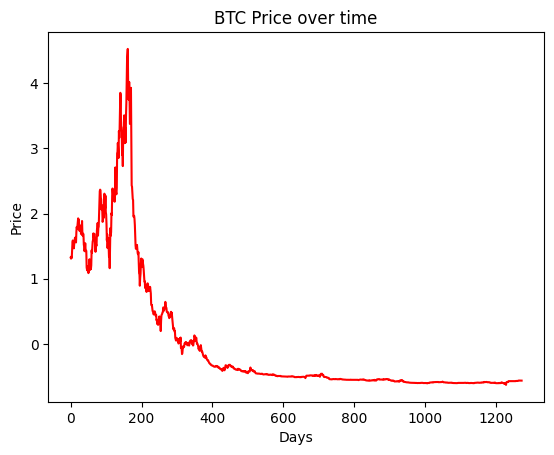

In [5]:
# plot to view the price of BTC over time

plt.title('BTC Price over time')
plt.plot(data, c="r")
plt.xlabel('Days')
plt.ylabel('Price')

In [6]:
# function to get data according to window size
def get_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    assert len(X) == len(y)
    return X, y

# consider window size 7 and get data
X, y = get_data(data, window_size = 7)

In [7]:
# train (first 1000 points) test split

X_train, y_train = np.array(X[:1000]), np.array(y[:1000])

X_test, y_test = np.array(X[1000:]), np.array(y[1000:])

X_train.shape

(1000, 7, 1)

In [8]:
# hyperparameters
batch_size = 7
window_size = 7
hidden_layer = 256
learning_rate = 0.001

In [9]:
# placeholders for input and output
input = tf.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.placeholder(tf.float32, [batch_size, 1])

In [10]:
# define weights to use in LSTM cell

# weights for input gate
U_i = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.Variable(tf.zeros([hidden_layer]))

# weights for forget gate
U_f = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.Variable(tf.zeros([hidden_layer]))

# weights for output gate
U_o = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.zeros([hidden_layer]))

# weights for candidate state
U_g = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.zeros([hidden_layer]))

# weights for output layer
V = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))

In [11]:
# define the LSTM Cell

def LSTM_cell(input, prev_hidden_state, prev_cell_state):
    it = tf.sigmoid(tf.matmul(input, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)
    ft = tf.sigmoid(tf.matmul(input, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)
    ot = tf.sigmoid(tf.matmul(input, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)
    gt = tf.tanh(tf.matmul(input, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)
    ct = (prev_cell_state * ft) + (it * gt)
    ht = ot * tf.tanh(ct)
    return ct, ht

In [12]:
# define forward prop

y_hat = []
for i in range(batch_size):
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32)
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state)
    y_hat.append(tf.matmul(hidden_state, V) + b_v)

In [13]:
# define back prop
losses = []

for i in range(len(y_hat)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(target[i], (-1, 1)), y_hat[i]))
loss = tf.reduce_mean(losses)

# gradient clipping to avoid exploding gradient problem
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

# use adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.trainable_variables()))

In [14]:
# train LSTM

session = tf.Session()
session.run(tf.global_variables_initializer())

epochs = 100

for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []
    while(index + batch_size) <= len(X_train):
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})
        epoch_loss.append(loss_val)
        train_predictions.append(predicted)
        index += batch_size
    if (i % 10)== 0:
        print(f"Epoch {i}, Loss: {np.mean(epoch_loss)}")

2025-04-28 18:32:10.624367: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745844430.660443   18323 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Epoch 0, Loss: 0.1993260234594345
Epoch 10, Loss: 0.04843957722187042
Epoch 20, Loss: 0.03012985922396183
Epoch 30, Loss: 0.017626019194722176
Epoch 40, Loss: 0.0186790619045496
Epoch 50, Loss: 0.009517835453152657
Epoch 60, Loss: 0.01027981098741293
Epoch 70, Loss: 0.010378513485193253
Epoch 80, Loss: 0.008158589713275433
Epoch 90, Loss: 0.007359115872532129


In [15]:
# make predictions using LSTM
predicted_output = []
i = 0

while i+batch_size <= len(X_test):
    output = session.run([y_hat],feed_dict={input:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)
    
predicted_output[0]

[[array([[-0.60264766]], dtype=float32),
  array([[-0.59974945]], dtype=float32),
  array([[-0.5992061]], dtype=float32),
  array([[-0.5978694]], dtype=float32),
  array([[-0.5977099]], dtype=float32),
  array([[-0.5993786]], dtype=float32),
  array([[-0.5953332]], dtype=float32)]]

In [33]:
# flatten test predictions
predicted_values_test = []
for i in range(len(predicted_output)):
    for j in range(len(predicted_output[i][0])):
        predicted_values_test.append(predicted_output[i][0][j])

predicted_values_test[0]

array([[-0.60264766]], dtype=float32)

In [54]:
predicted_values_test = [x for x in predicted_values_test]

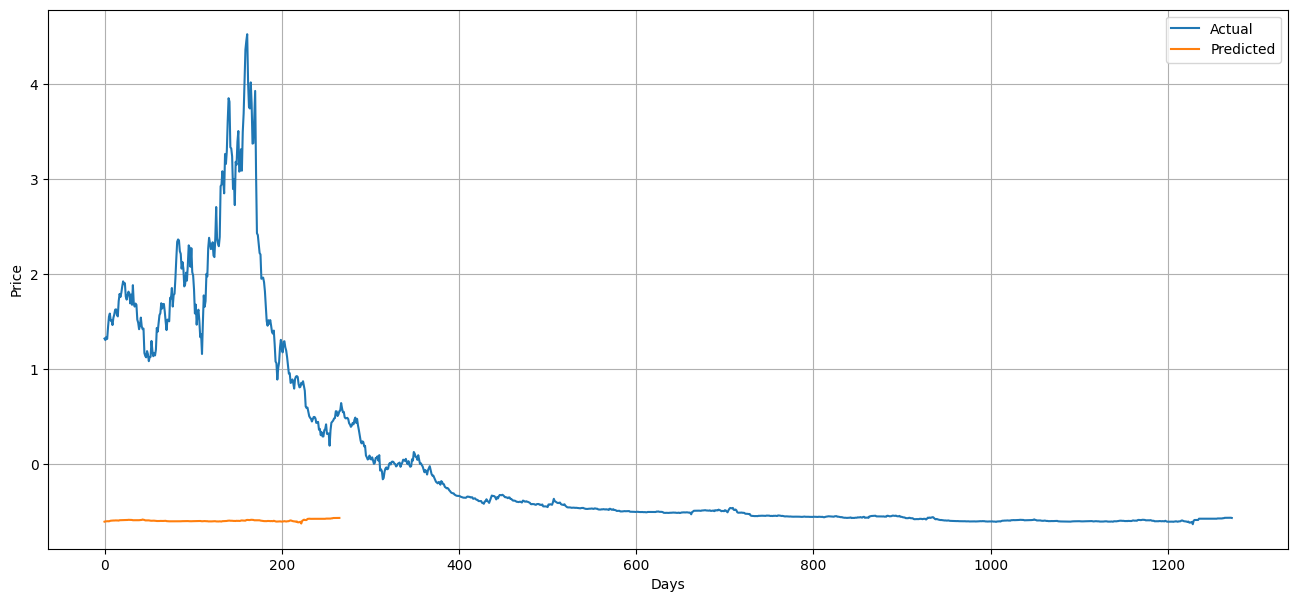

In [55]:
# visualize predicted value and true value

plt.figure(figsize=(16, 7))
plt.plot(data, label='Actual')
plt.plot(predicted_values_test, label='Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()
plt.show()